## I. Referential of New York Vtc's served zones
### a. Quick view of data

In [177]:
!wget \
    -q https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv \
    -O data/taxi_zone_lookup.csv \
    -nc
    
import pandas as pd
import os

lookup = pd.read_csv(
    os.path.expanduser("data/taxi_zone_lookup.csv")
)

lookup.head(5)

93968.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


### b. Load more detailed geographical data

In [ ]:
!wget -q https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip -O data/taxi_zones.zip
!unzip -q data/taxi_zones.zip -d data/taxi_zones
!rm data/taxi_zones.zip

In [21]:
import geopandas
zones = geopandas.read_file(
    os.path.expanduser("data/taxi_zones/taxi_zones.shp")
)
zones.head(5)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


##### The values in **geometry** column have no meaning for us.
We need to convert them to more familiar and *readable* values : norm "**EPSG:4326**" of basic Longitudes and latitudes.  
Then we calculate the central point of this shapes to have a little more understanding of the data

In [27]:
zones_gps = zones.to_crs("EPSG:4326")

#calculate the central points of this locations
def get_center(zone):
    zone["longitude"] = zone["geometry"].centroid.x
    zone["latitude"] = zone["geometry"].centroid.y
    return zone

coord_zones = zones_gps.apply(get_center,axis=1)
coord_zones.head(5)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188484,40.552659


<Axes: >

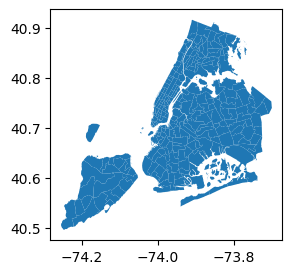

In [35]:
coord_zones.plot(figsize=(3,3))

### b. explore & understand data : for the sake of **Data Quality**

In [49]:
counts = coord_zones['LocationID'].value_counts()
filtered_counts = counts[counts>1]
filtered_counts

LocationID
103    3
56     2
Name: count, dtype: int64

In [52]:
coord_zones[coord_zones['LocationID'] == 103]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,longitude,latitude
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((-74.04389 40.69018, -74.04351 40.689...",-74.045288,40.689860
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((-74.03995 40.70089, -74.03945 40.700...",-74.040771,40.698769
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((-74.01675 40.69334, -74.01540 40.693...",-74.019073,40.688784


#### IV. Cleaning Data 

In [169]:
geo_table = coord_zones \
    .drop(['Shape_Leng', 'Shape_Area', 'LocationID'], axis=1) \
    .rename({'OBJECTID': 'id'}, axis=1)
geo_table['geometry'] = geo_table['geometry'].astype(str)
### truncate data because refshift doesn't allow more than varchar(65535)
geo_table['geometry'] = geo_table['geometry'].apply(lambda x: x[:65534] if len(x) > 65535 else x)

geo_table.head()

/var/folders/df/y37mfjb960l1q4mj840br9p80000gn/T/ipykernel_36070/1974405263.py:4: UserWarning: Geometry column does not contain geometry.
  geo_table['geometry'] = geo_table['geometry'].astype(str)
/var/folders/df/y37mfjb960l1q4mj840br9p80000gn/T/ipykernel_36070/1974405263.py:5: UserWarning: Geometry column does not contain geometry.
  geo_table['geometry'] = geo_table['geometry'].apply(lambda x: x[:65534] if len(x) > 65535 else x)


,id,zone,borough,geometry,longitude,latitude
0,1,Newark Airport,EWR,"POLYGON ((-74.184453 40.694996, -74.184489 40....",-74.174000,40.691831
1,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.823376 40.638987, -73.8227...",-73.831299,40.616745
2,3,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.847926 40.871342, -73.847251 40....",-73.847422,40.864474
3,4,Alphabet City,Manhattan,"POLYGON ((-73.971774 40.725821, -73.971791 40....",-73.976968,40.723752
4,5,Arden Heights,Staten Island,"POLYGON ((-74.174217 40.562568, -74.173485 40....",-74.188484,40.552659


In [170]:
geo_table.to_csv('data/geographical_zones.csv',index=False)

# II. Load data to datawarehouse in Redshift
### a. Load intermediary to datalake in s3
in order to use boto3 and access aws services, we need to first configure aws access.

using the AWS Cli, **aws configure** and create access keys for a specific non-root user with the least privileges.  
but this method generates long-term access keys which is not recommended.

 - The best practice : Use temporary security credentials  ( coming ) 

In [173]:
import boto3

s3_client = boto3.client('s3')
filename = 'data/geographical_zones.csv'
bucket_name = 'datalake-vtc'

s3_client.upload_file(filename, bucket_name, 'referential/geographical_zones.csv')

### b. Load data to Redshift

In [178]:
import  psycopg2
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

# Accessing the values
dbname = config['database']['dbname']
user = config['database']['user']
password = config['database']['password']
host = config['database']['host']
port = config['database']['port']

s3_path = config['s3_redshift']['s3_path']
iam_role_arn = config['s3_redshift']['iam_role_arn']

def exec_sql_command(sql_command):
    # Establish a connection to Redshift
    conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
    cur = conn.cursor()

    cur.execute(sql_command)
    conn.commit()

    # Close the cursor and the connection
    cur.close()
    conn.close()

In [179]:
# Create table command
create_table_command = f"""
CREATE TABLE IF NOT EXISTS public.areas (
    id INT PRIMARY KEY,
    zone VARCHAR(256),
    borough VARCHAR(256),
    geometry VARCHAR(max),  
    longitude FLOAT,
    latitude FLOAT
);
"""

exec_sql_command(create_table_command)

In [176]:
# Form the COPY command
copy_command = f"""
COPY public.areas
FROM '{s3_path}'
CSV
IAM_ROLE '{iam_role_arn}'
DELIMITER ','
QUOTE '"'
IGNOREHEADER 1
REGION 'eu-west-3';
"""

exec_sql_command(copy_command)